<a href="https://colab.research.google.com/github/Abhinav-Marlingaplar/Optimisation-Algorithms-for-Data-Science/blob/main/IMA314_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMA314 Optimization techniques for Data Science**
## *Name - Abhinav Marlingaplar*
## *Roll No - 2023BCD0013*

# **Description:**
This notebook demonstrates key optimization algorithms and concepts
commonly used in data science. Each section includes implementation,
visualization, and analysis of optimization techniques ranging from
Hessian properties to advanced adaptive methods and constrained optimization.

# **Importing necessary libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, make_classification
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)


# **1] Types of Hessian:**
Objective:
-----------
To study the nature of different Hessian matrices (second-order derivatives)
and understand their influence on curvature and critical points.

Concept:
---------
For a scalar function f(x, y) = 0.5 * [x y]ᵀ A [x y],
the Hessian matrix H = A determines the function’s curvature:
- Positive definite → Local minimum
- Positive semi-definite → Flat or saddle with zero curvature
- Negative definite → Local maximum
- Negative semi-definite → Flat or saddle with negative curvature
- Indefinite → Saddle point

Visualization:
---------------
Each Hessian type is visualized using:
1. Contour plot (showing level sets of f)
2. 3D surface plot (showing curvature in 3D)


In [ ]:
print('\nSECTION 1: Hessian types')

# We'll use simple quadratic forms f(x) = 0.5 (x^T) (A) (x)
# Hessian is A (constant). We'll visualize eigenvalues and contour plots.

def show_hessian_example(A, title):
    print(title)
    print('Matrix A =')
    print(A)
    eigs = np.linalg.eigvals(A)
    print('Eigenvalues:', np.round(eigs,4))


    # Define grid and compute quadratic form
    x = np.linspace(-3,3,201)
    X,Y = np.meshgrid(x,x)
    Z = 0.5*(A[0,0]*X**2 + 2*A[0,1]*X*Y + A[1,1]*Y**2)


    # Create figure with two subplots side by side
    fig = plt.figure(figsize=(12,5))


    # Contour plot
    ax1 = fig.add_subplot(1,2,1)
    cs = ax1.contour(X,Y,Z,30)
    ax1.clabel(cs, inline=1, fontsize=8)
    ax1.set_title(title + '\n(Contour Plot)')
    ax1.axhline(0,color='k',linewidth=0.5); ax1.axvline(0,color='k',linewidth=0.5)
    ax1.set_aspect('equal', 'box')
    ax1.set_xlabel('x'); ax1.set_ylabel('y')


    # 3D Surface plot
    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.plot_surface(X, Y, Z, cmap='viridis', alpha=0.9, linewidth=0)
    ax2.set_title(title + '\n(3D Surface)')
    ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('f(x,y)')


    plt.tight_layout()
    plt.show()


SECTION 1: Hessian types


## **1.1 ] Positive definite Hessian**

Positive definite Hessian (all eigenvalues > 0)
Matrix A =
[[2.  0.5]
 [0.5 1.5]]
Eigenvalues: [2.309 1.191]


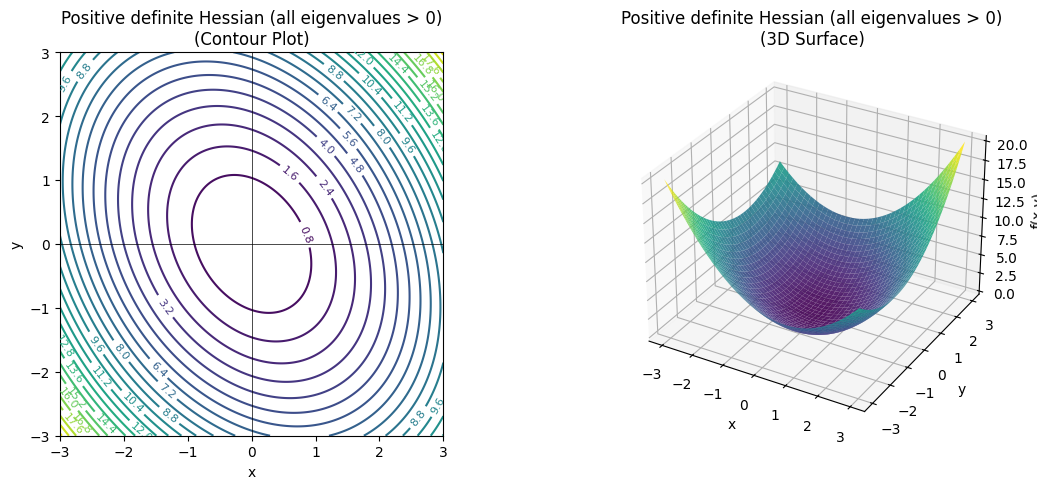

In [ ]:
# Positive definite
A_pd = np.array([[2.0, 0.5],[0.5, 1.5]])
show_hessian_example(A_pd, 'Positive definite Hessian (all eigenvalues > 0)')

## **1.2 ] Positive Semi definite Hessian**

Positive semi-definite Hessian (eigs >= 0)
Matrix A =
[[ 1. -1.]
 [-1.  1.]]
Eigenvalues: [2. 0.]


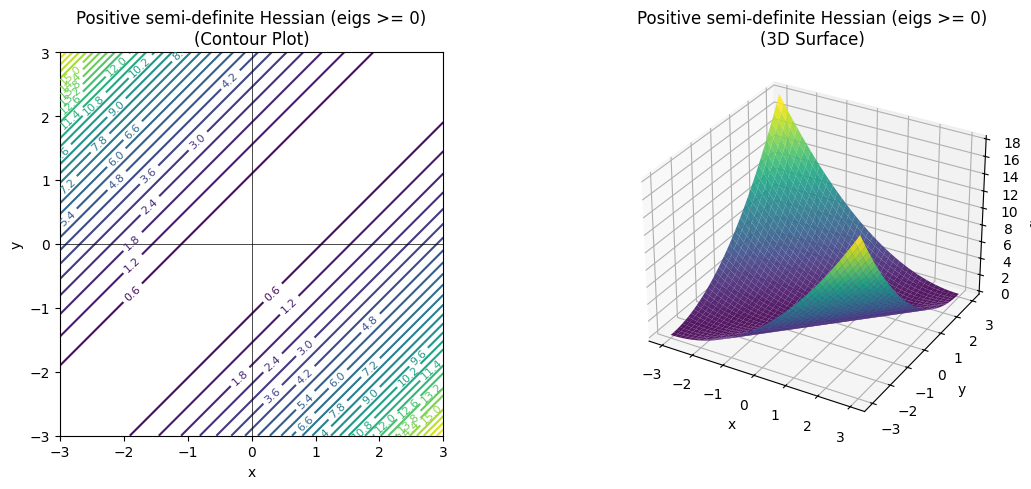

In [ ]:
# Positive semi-definite
A_psd = np.array([[1.0, -1.0],[-1.0, 1.0]]) # rank-1 (eigs: 2,0)
show_hessian_example(A_psd, 'Positive semi-definite Hessian (eigs >= 0)')

## **1.3 ] Negative definite Hessian**

Negative definite Hessian (all eigenvalues < 0)
Matrix A =
[[-2.  -0.5]
 [-0.5 -1.5]]
Eigenvalues: [-2.309 -1.191]


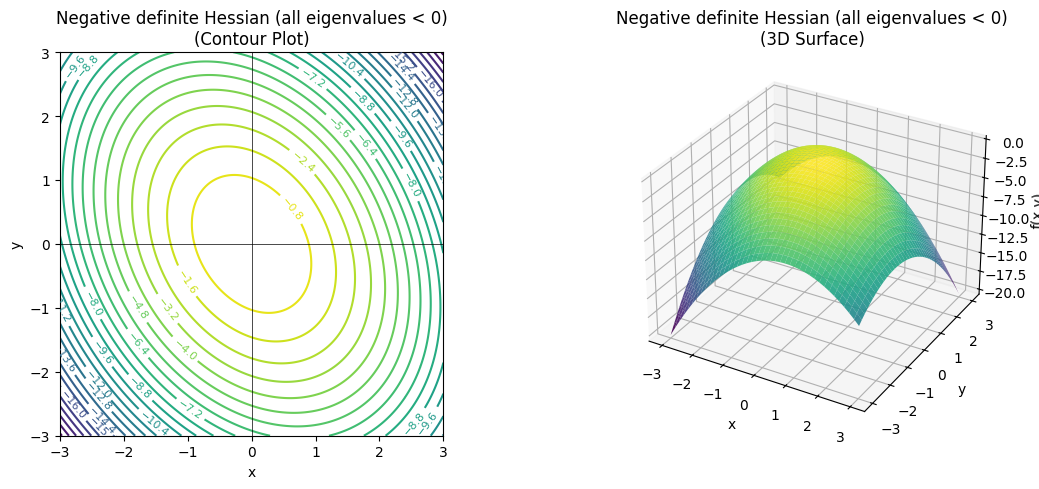

In [ ]:
# Negative definite
A_nd = -A_pd
show_hessian_example(A_nd, 'Negative definite Hessian (all eigenvalues < 0)')

## **1.4 ] Negative Semi definite Hessian**

Negative semi-definite Hessian (eigs <= 0)
Matrix A =
[[-1.  1.]
 [ 1. -1.]]
Eigenvalues: [ 0. -2.]


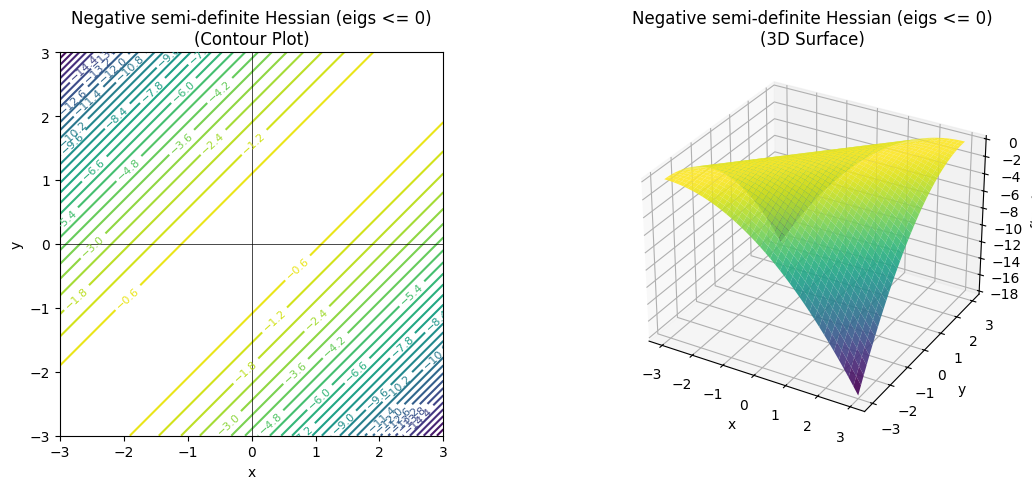

In [ ]:
# Negative semi-definite
A_nsd = -A_psd
show_hessian_example(A_nsd, 'Negative semi-definite Hessian (eigs <= 0)')

## **1.5 ] Indefinite Hessian**

Indefinite Hessian (mixed signs)
Matrix A =
[[ 2.  0.]
 [ 0. -1.]]
Eigenvalues: [ 2. -1.]


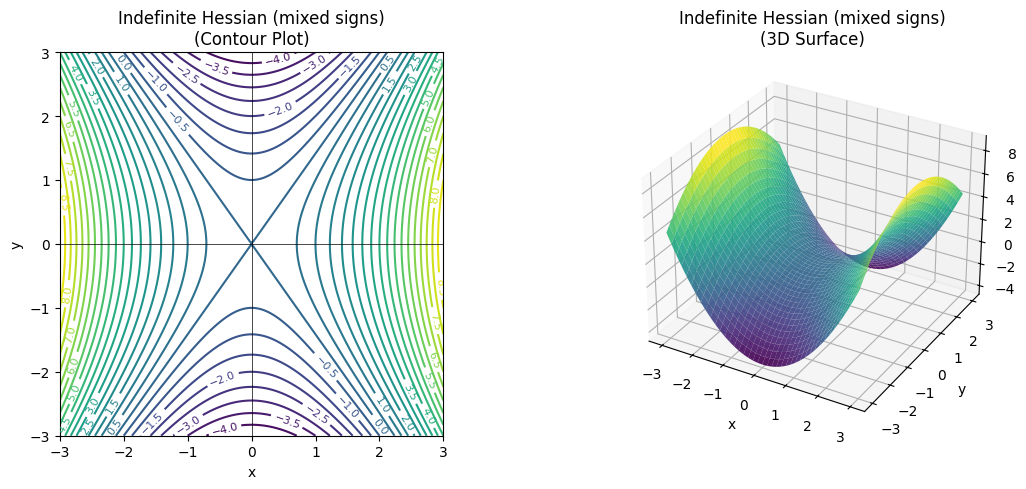

In [ ]:
# Indefinite
A_indef = np.array([[2.0,0],[0,-1.0]])
show_hessian_example(A_indef, 'Indefinite Hessian (mixed signs)')

# **2] Gradient descent variants on a simple 2D function (quadratic + noise)**
Objective:
-----------
To implement and visualize different forms of Gradient Descent (GD) used for
minimizing convex quadratic functions. We demonstrate:

1. Standard (Fixed Learning Rate) Gradient Descent
2. Armijo Backtracking Line Search (adaptive learning rate)
3. Momentum Gradient Descent (accelerated convergence)
4. Nesterov Accelerated Gradient Descent (NAG)

Mathematical Formulation:
--------------------------
For a quadratic function:
    f(x) = 0.5 * xᵀQx + bᵀx
Gradient: ∇f(x) = Qx + b

Each variant modifies the update rule for x differently.


In [ ]:
print('\nSECTION 2: Gradient descent variants')

# Define function and gradient
Q = np.array([[3.0, 0.5],[0.5, 1.0]])
b = np.array([0.5, -0.2])

def f_quad(x):
    return 0.5*x.T@Q@x + b.T@x

def grad_quad(x):
    return Q@x + b

x0 = np.array([2.5,2.0])


SECTION 2: Gradient descent variants


In [ ]:
# Helper function to visualize contour + loss side by side (with step markers)
def plot_contour_and_loss(Q, b, traj, losses, title):
    x = np.linspace(-3, 3, 200)
    y = np.linspace(-3, 3, 200)
    X, Y = np.meshgrid(x, y)
    Z = 0.5*(Q[0,0]*X**2 + 2*Q[0,1]*X*Y + Q[1,1]*Y**2) + b[0]*X + b[1]*Y

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # --- Contour plot with trajectory ---
    cs = ax[0].contour(X, Y, Z, 30)
    ax[0].clabel(cs, inline=1, fontsize=8)
    ax[0].plot(traj[:, 0], traj[:, 1], 'r-', label='Path')
    ax[0].scatter(traj[:, 0], traj[:, 1], color='red', s=20, label='Steps')  # Step markers
    ax[0].scatter(traj[0, 0], traj[0, 1], color='green', s=40, label='Start', zorder=5)
    ax[0].scatter(traj[-1, 0], traj[-1, 1], color='black', s=40, label='End', zorder=5)
    ax[0].set_title(f'{title} - Trajectory')
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[0].legend()
    ax[0].grid(True)

    # --- Loss plot with step points ---
    ax[1].plot(losses, 'b-', label='Loss')
    ax[1].scatter(np.arange(len(losses)), losses, color='blue', s=25, label='Steps')  # Step markers
    ax[1].set_title(f'{title} - Loss Curve')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


## **2.1] Regular Gradient Descent**

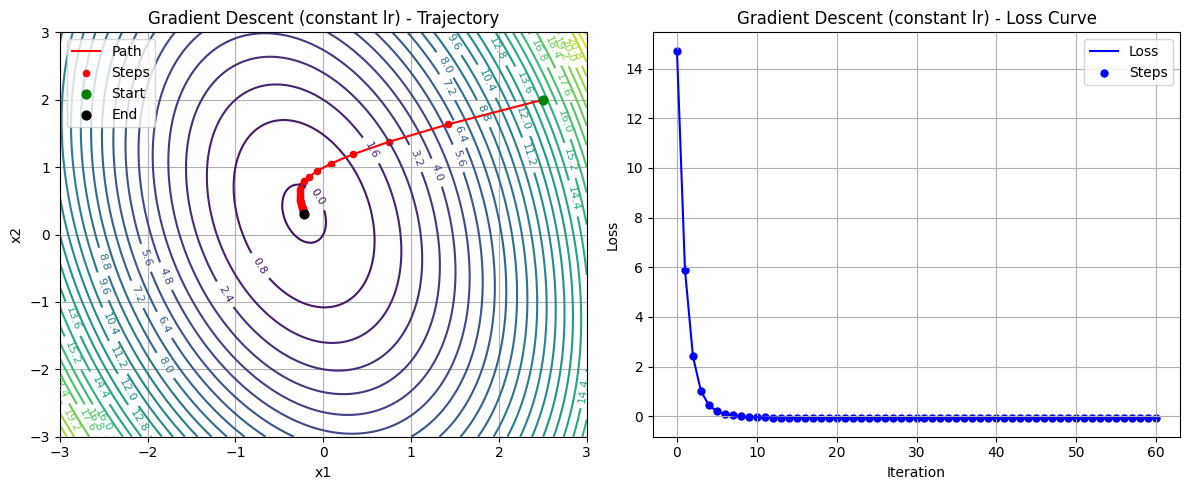

In [ ]:
# Regular GD
def gradient_descent(grad, x0, lr=0.1, steps=80):
    x = x0.copy().astype(float)
    traj = [x.copy()]
    losses = [f_quad(x)]
    for i in range(steps):
        x = x - lr*grad(x)
        traj.append(x.copy()); losses.append(f_quad(x))
    return np.array(traj), np.array(losses)


traj_gd, losses_gd = gradient_descent(grad_quad, x0, lr=0.12, steps=60)
plot_contour_and_loss(Q, b, traj_gd, losses_gd, 'Gradient Descent (constant lr)')

## **2.2 ] Armijo Backtracking**

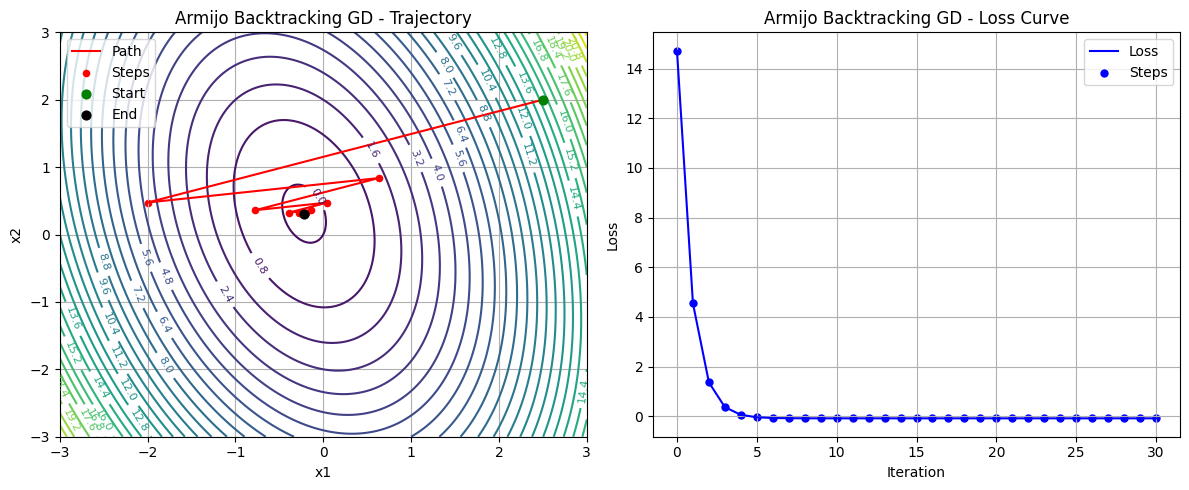

In [ ]:
# Armijo backtracking
def armijo_gd(f, grad, x0, alpha0=1.0, c=1e-4, rho=0.5, steps=30):
    x = x0.copy().astype(float)
    traj=[x.copy()]; losses=[f(x)]
    for i in range(steps):
        d = -grad(x)
        alpha = alpha0
        while f(x + alpha*d) > f(x) + c*alpha*grad(x).dot(d):
          alpha = rho*alpha
        x = x + alpha*d
        traj.append(x.copy()); losses.append(f(x))
    return np.array(traj), np.array(losses)


traj_armijo, losses_armijo = armijo_gd(f_quad, grad_quad, x0, steps=30)
plot_contour_and_loss(Q, b, traj_armijo, losses_armijo, 'Armijo Backtracking GD')

## **2.3 ] Momentum**

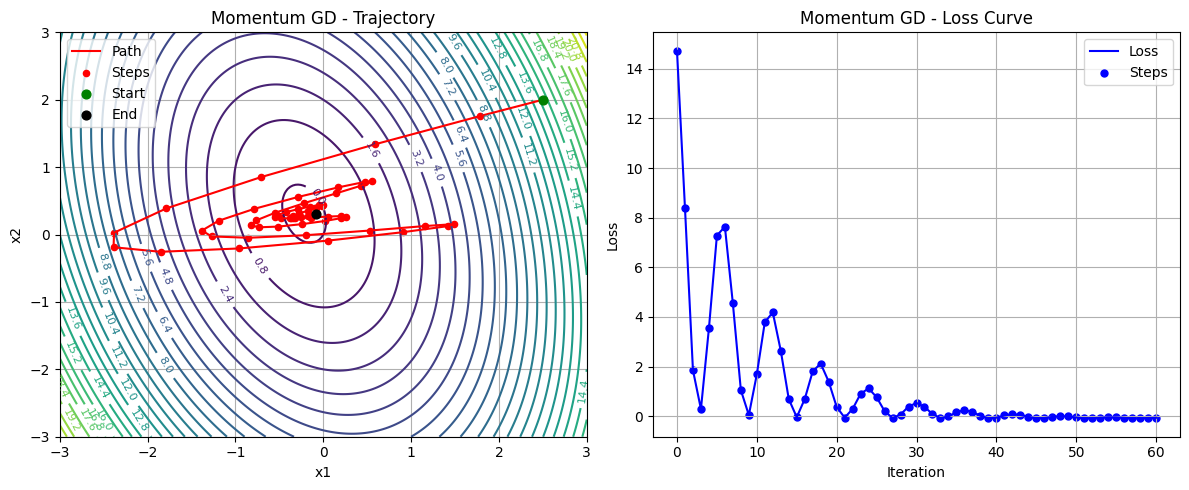

In [ ]:
# Momentum
def momentum_gd(grad, x0, lr=0.1, beta=0.9, steps=60):
    x = x0.copy().astype(float)
    v = np.zeros_like(x)
    traj=[x.copy()]; losses=[f_quad(x)]
    for i in range(steps):
        v = beta*v + lr*grad(x)
        x = x - v
        traj.append(x.copy()); losses.append(f_quad(x))
    return np.array(traj), np.array(losses)


traj_mom, losses_mom = momentum_gd(grad_quad, x0, lr=0.08, beta=0.9)
plot_contour_and_loss(Q, b, traj_mom, losses_mom, 'Momentum GD')

## **2.4 ] Nesterov Accelerated Gradient (NAG)**

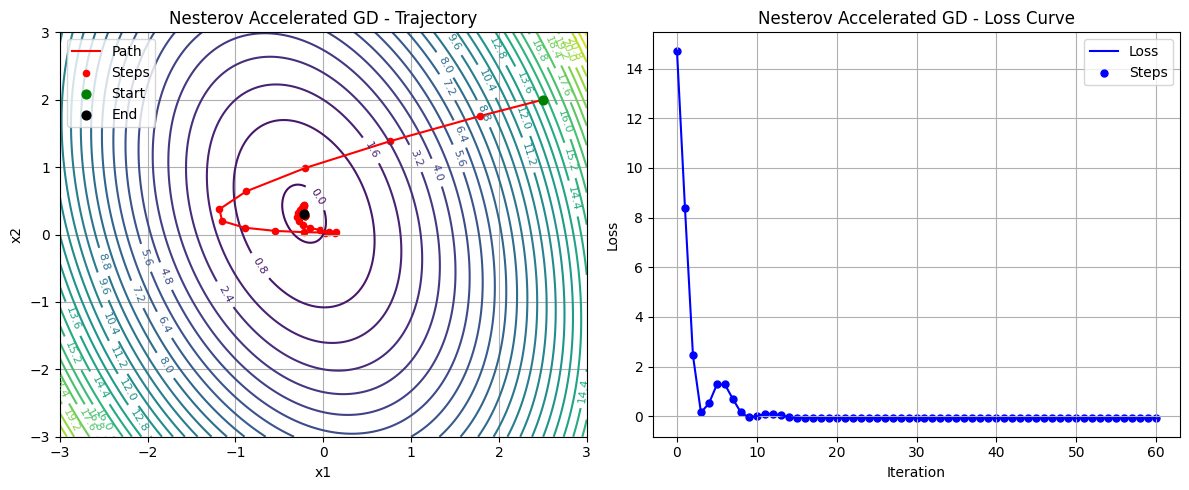

In [ ]:
# Nesterov
def nesterov_gd(grad, x0, lr=0.08, beta=0.9, steps=60):
    x = x0.copy().astype(float)
    v = np.zeros_like(x)
    traj=[x.copy()]; losses=[f_quad(x)]
    for i in range(steps):
        lookahead = x - beta*v
        g = grad(lookahead)
        v = beta*v + lr*g
        x = x - v
        traj.append(x.copy()); losses.append(f_quad(x))
    return np.array(traj), np.array(losses)


traj_nes, losses_nes = nesterov_gd(grad_quad, x0)
plot_contour_and_loss(Q, b, traj_nes, losses_nes, 'Nesterov Accelerated GD')

## **2.5 ] Comparison of all Variants of Gradient Descent**

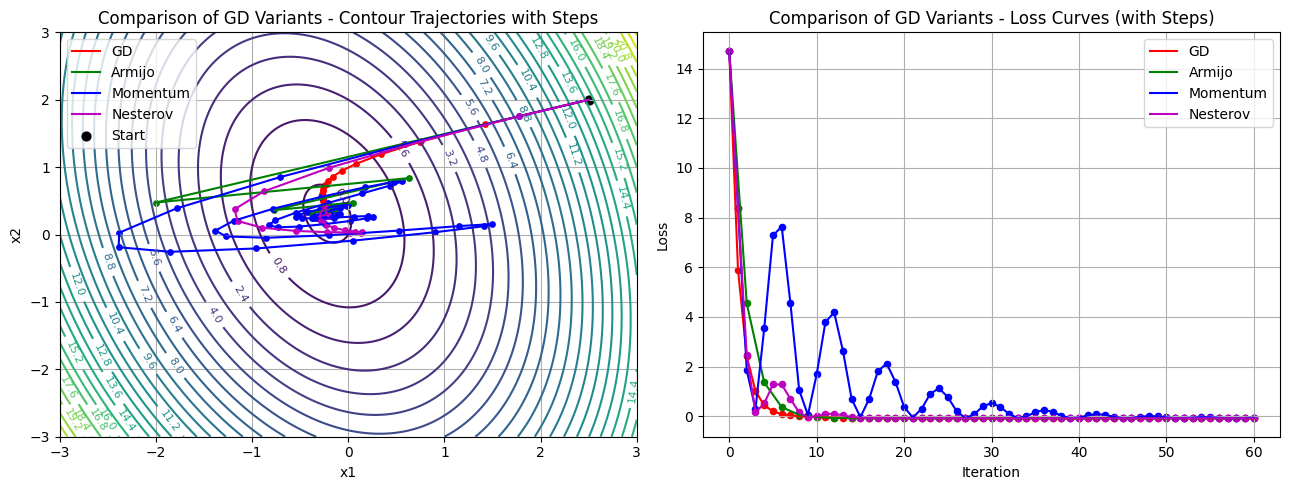

In [ ]:
# Compare all GD variants on contour and loss side by side

x = np.linspace(-3, 3, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)
Z = 0.5*(Q[0,0]*X**2 + 2*Q[0,1]*X*Y + Q[1,1]*Y**2) + b[0]*X + b[1]*Y

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# --- Left: Contour with all trajectories + step points ---
cs = ax[0].contour(X, Y, Z, 30)
ax[0].clabel(cs, inline=1, fontsize=8)

# GD
ax[0].plot(traj_gd[:,0], traj_gd[:,1], 'r', label='GD')
ax[0].scatter(traj_gd[:,0], traj_gd[:,1], color='r', s=15)

# Armijo
ax[0].plot(traj_armijo[:,0], traj_armijo[:,1], 'g', label='Armijo')
ax[0].scatter(traj_armijo[:,0], traj_armijo[:,1], color='g', s=15)

# Momentum
ax[0].plot(traj_mom[:,0], traj_mom[:,1], 'b', label='Momentum')
ax[0].scatter(traj_mom[:,0], traj_mom[:,1], color='b', s=15)

# Nesterov
ax[0].plot(traj_nes[:,0], traj_nes[:,1], 'm', label='Nesterov')
ax[0].scatter(traj_nes[:,0], traj_nes[:,1], color='m', s=15)

# Start point
ax[0].scatter(x0[0], x0[1], color='black', s=40, marker='o', label='Start')

ax[0].set_title('Comparison of GD Variants - Contour Trajectories with Steps')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].legend()
ax[0].grid(True)

# --- Right: Combined Loss Curves (with step markers) ---
ax[1].plot(losses_gd, 'r', label='GD')
ax[1].scatter(np.arange(len(losses_gd)), losses_gd, color='r', s=20)

ax[1].plot(np.linspace(0, len(losses_gd)-1, len(losses_armijo)), losses_armijo, 'g', label='Armijo')
ax[1].scatter(np.linspace(0, len(losses_gd)-1, len(losses_armijo)), losses_armijo, color='g', s=20)

ax[1].plot(losses_mom, 'b', label='Momentum')
ax[1].scatter(np.arange(len(losses_mom)), losses_mom, color='b', s=20)

ax[1].plot(losses_nes, 'm', label='Nesterov')
ax[1].scatter(np.arange(len(losses_nes)), losses_nes, color='m', s=20)

ax[1].set_title('Comparison of GD Variants - Loss Curves (with Steps)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)


plt.tight_layout()
plt.show()


# **3] Gradient descent over Linear regression - normal GD and stochastic GD**

Objective:
-----------
To apply gradient descent (GD) and stochastic gradient descent (SGD)
to a simple linear regression model, compare convergence, and visualize
fitted lines versus closed-form (normal equation) solution.

Concept:
---------

*   **The Mean Squared Error (MSE) is minimized:** J(w) = (1/2n) ||Xw - y||²
*   **Gradient:** ∇J(w) = (1/n) Xᵀ(Xw - y)





In [ ]:
print('\nSECTION 3: Linear Regression GD and SGD')

# Create synthetic linear dataset
X, y, coef = make_regression(n_samples=500, n_features=1, noise=10.0, coef=True, random_state=1)
X = X.reshape(-1,1)

# add bias column
X_with_bias = np.hstack([np.ones((X.shape[0],1)), X])

# Closed-form solution for reference
w_closed = np.linalg.pinv(X_with_bias.T@X_with_bias) @ X_with_bias.T @ y
print('Closed-form weights (bias, slope):', w_closed)


SECTION 3: Linear Regression GD and SGD
Closed-form weights (bias, slope): [ 0.08799902 21.54848463]


In [ ]:
# MSE and gradient
def mse_loss(w, Xb, y):
  preds = Xb@w
  err = preds - y
  return 0.5*np.mean(err**2)


def grad_mse(w, Xb, y):
  preds = Xb@w
  err = preds - y
  return (Xb.T@err)/Xb.shape[0]

In [ ]:
# Utility plotting function
def plot_trajectory(xs, ys, title, xlabel='x', ylabel='y'):
    plt.figure(figsize=(6,4))
    plt.plot(xs, ys, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

## **3.1 ] Normal Gradient Descent**

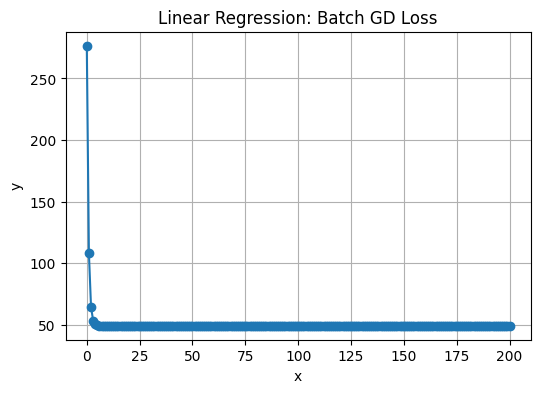

In [ ]:
# GD
def linear_gd(Xb, y, lr=0.1, steps=200):
  w = np.zeros(Xb.shape[1])
  traj=[w.copy()]; losses=[mse_loss(w,Xb,y)]
  for i in range(steps):
    g = grad_mse(w,Xb,y)
    w = w - lr*g
    traj.append(w.copy()); losses.append(mse_loss(w,Xb,y))
  return np.array(traj), np.array(losses)

traj_lin_gd, losses_lin_gd = linear_gd(X_with_bias, y, lr=0.5, steps=200)
plot_trajectory(np.arange(len(losses_lin_gd)), losses_lin_gd, 'Linear Regression: Batch GD Loss')

## **3.2 ] Stochastic Gradient Descent**

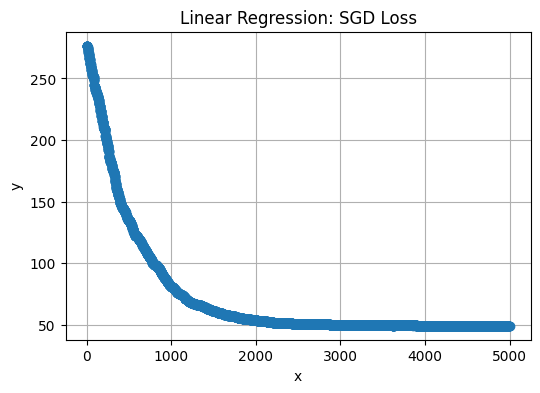

In [ ]:
# Stochastic GD
def linear_sgd(Xb, y, lr=0.01, epochs=5):
    w = np.zeros(Xb.shape[1])
    traj=[w.copy()]; losses=[mse_loss(w,Xb,y)]
    n = Xb.shape[0]
    for ep in range(epochs):
        perm = np.random.permutation(n)
        for i in perm:
            xi = Xb[i:i+1,:]
            yi = y[i:i+1]
            g = (xi.T@(xi@w - yi)).ravel()
            w = w - lr*g
            traj.append(w.copy()); losses.append(mse_loss(w,Xb,y))
    return np.array(traj), np.array(losses)


traj_lin_sgd, losses_lin_sgd = linear_sgd(X_with_bias, y, lr=0.001, epochs=10)
plot_trajectory(np.arange(len(losses_lin_sgd)), losses_lin_sgd, 'Linear Regression: SGD Loss')

## **3.3 ] Comparison of Normal GD and Stochastic GD**

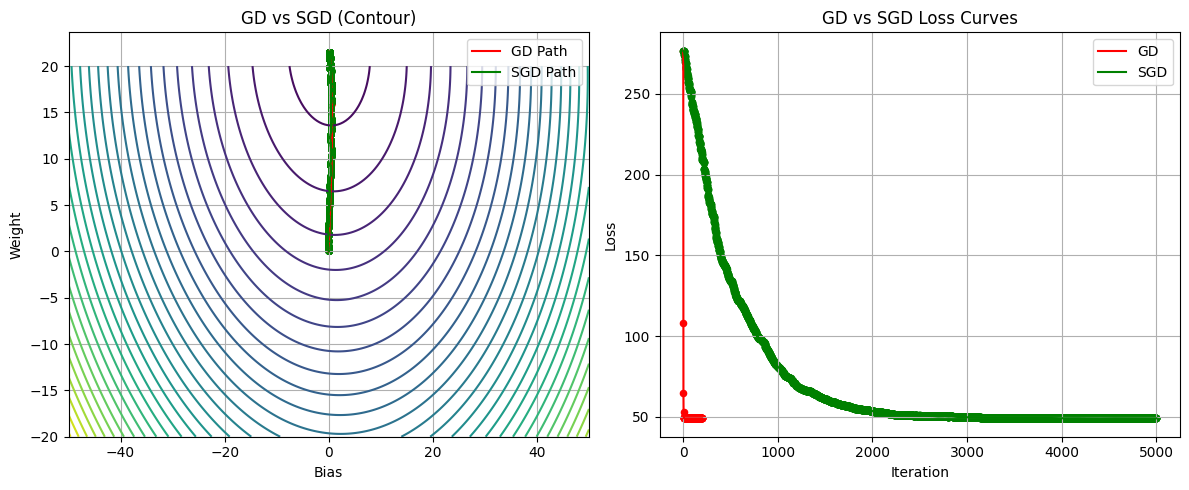

In [ ]:
# --- Contour + Loss side by side ---
b_vals = np.linspace(-50, 50, 200)
w_vals = np.linspace(-20, 20, 200)
B, W = np.meshgrid(b_vals, w_vals)
Z = np.zeros_like(B)
for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        w_temp = np.array([B[i,j], W[i,j]])
        Z[i,j] = mse_loss(w_temp, X_with_bias, y)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Left: Contour
cs = ax[0].contour(B, W, Z, 30)
ax[0].plot(traj_lin_gd[:,0], traj_lin_gd[:,1], 'r-', label='GD Path')
ax[0].scatter(traj_lin_gd[:,0], traj_lin_gd[:,1], c='r', s=15)  # mark GD points
ax[0].plot(traj_lin_sgd[:,0], traj_lin_sgd[:,1], 'g-', label='SGD Path')
ax[0].scatter(traj_lin_sgd[:,0], traj_lin_sgd[:,1], c='g', s=15)  # mark SGD points
ax[0].set_xlabel('Bias'); ax[0].set_ylabel('Weight')
ax[0].set_title('GD vs SGD (Contour)')
ax[0].legend(); ax[0].grid(True)

# Right: Loss Curves
ax[1].plot(losses_lin_gd, 'r-', label='GD')
ax[1].scatter(range(len(losses_lin_gd)), losses_lin_gd, c='r', s=20)  # mark GD losses
ax[1].plot(losses_lin_sgd, 'g-', label='SGD')
ax[1].scatter(range(len(losses_lin_sgd)), losses_lin_sgd, c='g', s=20)  # mark SGD losses
ax[1].set_title('GD vs SGD Loss Curves')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout(); plt.show()

## **3.4 ] Final Linear Regression fits**

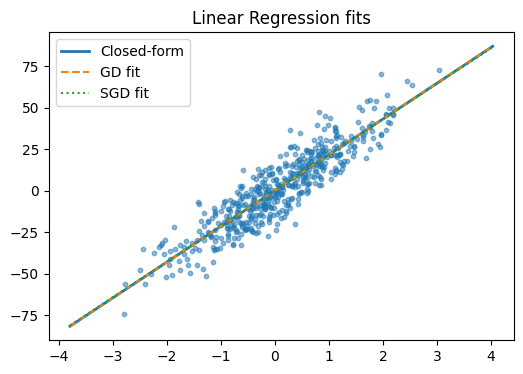

In [ ]:
# Show fit
plt.figure(figsize=(6,4))
plt.scatter(X, y, s=10, alpha=0.5)
xs = np.linspace(X.min()-1,X.max()+1,100)
plt.plot(xs, w_closed[0] + w_closed[1]*xs, label='Closed-form', linewidth=2)
plt.plot(xs, traj_lin_gd[-1,0] + traj_lin_gd[-1,1]*xs, '--', label='GD fit')
plt.plot(xs, traj_lin_sgd[-1,0] + traj_lin_sgd[-1,1]*xs, ':', label='SGD fit')
plt.legend(); plt.title('Linear Regression fits'); plt.show()

# **4] Gradient descent over logistic regression (GD)**

Objective:
-----------
Implement binary logistic regression and optimize the negative log-likelihood
with gradient descent. Visualize the log-loss convergence and the parameter
trajectory (w1 vs w2) on a contour of the log-loss (bias fixed for contour).

Concept:
--------
**Logistic model:**

p(y=1 | x) = sigmoid(w0 + w1 x1 + w2 x2)

**Negative log-likelihood (binary cross-entropy) is minimized:**

  L(w) = - (1/n) sum_i [ y_i log p_i + (1-y_i) log(1-p_i) ]

**Gradient is:**

X^T (p - y) / n

In [ ]:
print('\nSECTION 4: Logistic Regression via GD')

Xc, yc = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=2)
Xc = StandardScaler().fit_transform(Xc)
Xc_b = np.hstack([np.ones((Xc.shape[0],1)), Xc])

def sigmoid(z):
    return 1/(1+np.exp(-z))

def logloss_and_grad(w, Xb, y):
    """
    Compute negative log-likelihood and its gradient for logistic regression.
    Inputs:
      - w : parameter vector (including bias)
      - Xb: design matrix with bias column
      - y : binary labels (0/1)
    Returns:
      - loss : scalar log-loss
      - grad : gradient vector of same shape as w
    """
    z = Xb@w
    p = sigmoid(z)
    # log loss
    eps = 1e-9
    loss = -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
    grad = Xb.T@(p - y)/Xb.shape[0]
    return loss, grad


SECTION 4: Logistic Regression via GD


## **4.1 ] GD implementation**

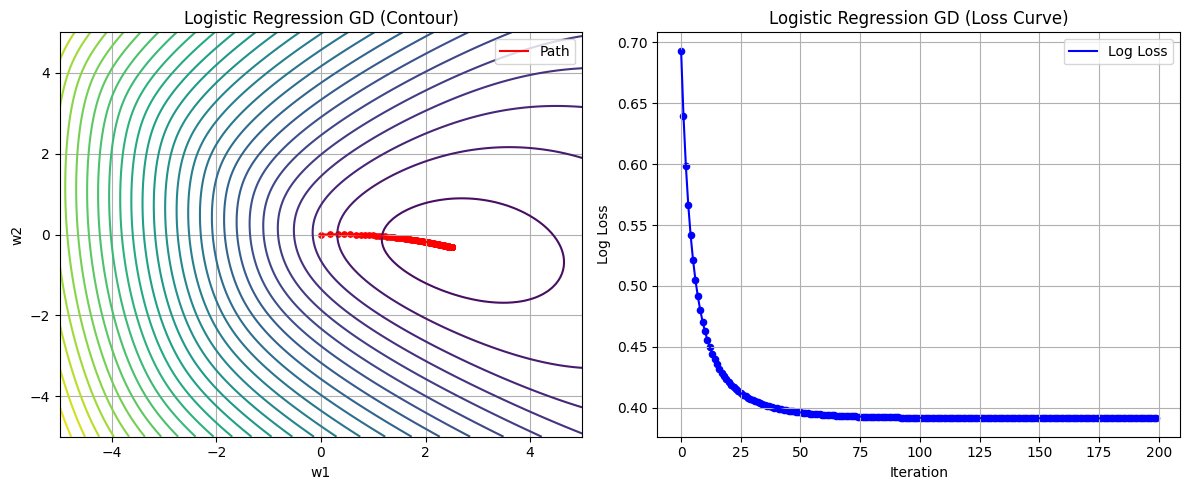

In [ ]:
# GD
w = np.zeros(Xc_b.shape[1])
losses = []
traj = [w.copy()]
for i in range(200):
    loss, g = logloss_and_grad(w, Xc_b, yc)
    w = w - 0.5*g
    losses.append(loss)
    traj.append(w.copy())
traj = np.array(traj)

# Contour + Loss side by side ---
w1 = np.linspace(-5, 5, 120)
w2 = np.linspace(-5, 5, 120)
W1, W2 = np.meshgrid(w1, w2)
Z = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w_temp = np.array([0, W1[i,j], W2[i,j]])
        z = Xc_b @ w_temp
        p = sigmoid(z)
        eps = 1e-9
        Z[i,j] = -np.mean(yc*np.log(p+eps) + (1-yc)*np.log(1-p+eps))

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Contour with path
cs = ax[0].contour(W1, W2, Z, 30)
ax[0].plot(traj[:,1], traj[:,2], 'r-', label='Path')
ax[0].scatter(traj[:,1], traj[:,2], c='r', s=15)  # mark each update point
ax[0].set_xlabel('w1'); ax[0].set_ylabel('w2')
ax[0].set_title('Logistic Regression GD (Contour)')
ax[0].legend(); ax[0].grid(True)

# Loss curve with points
ax[1].plot(losses, 'b-', label='Log Loss')
ax[1].scatter(range(len(losses)), losses, c='b', s=20)  # mark each iteration
ax[1].set_xlabel('Iteration'); ax[1].set_ylabel('Log Loss')
ax[1].set_title('Logistic Regression GD (Loss Curve)')
ax[1].legend(); ax[1].grid(True)

plt.tight_layout(); plt.show()

## **4.2 ] Visualize decision boundary**

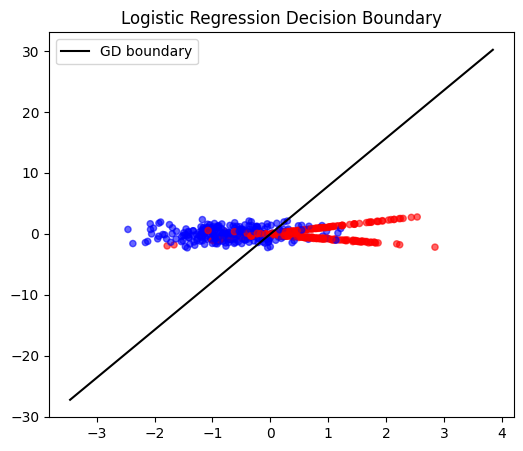

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(Xc[:,0], Xc[:,1], c=yc, s=20, cmap='bwr', alpha=0.6)
# decision boundary w0 + w1 x + w2 y = 0
xs = np.linspace(Xc[:,0].min()-1, Xc[:,0].max()+1, 100)
ys = -(w[0] + w[1]*xs)/w[2]
plt.plot(xs, ys, '-k', label='GD boundary')
plt.legend(); plt.title('Logistic Regression Decision Boundary'); plt.show()

# **5] Adaptive methods: Adagrad, EWMA smoothing, RMSProp, Adam**

Objective:
----------
Compare popular adaptive optimization algorithms that rescale gradients
differently based on historical gradient information:
- Adagrad: accumulates squared gradients and rescales updates.
- EWMA-smoothed GD: uses exponential moving average of gradients (visualized).
- RMSProp: maintains exponentially-weighted average of squared gradients.
- Adam: combines momentum (first moment) + RMSProp-style second moment.

We will visualize each optimizer's trajectory on the quadratic surface (contour)
and also plot the loss curves (with step markers).

In [ ]:
print('\nSECTION 5: Adaptive optimizers (Adagrad, EWMA, RMSProp, Adam) on simple quadratic')


SECTION 5: Adaptive optimizers (Adagrad, EWMA, RMSProp, Adam) on simple quadratic


In [ ]:
# Utility function to plot countour graph and loss curves side by side
def plot_contour_and_loss(Q, b, traj, losses, title, color='r'):
    x = np.linspace(-3,3,200)
    y = np.linspace(-3,3,200)
    X,Y = np.meshgrid(x,y)
    Z = 0.5*(Q[0,0]*X**2 + 2*Q[0,1]*X*Y + Q[1,1]*Y**2) + b[0]*X + b[1]*Y

    fig, ax = plt.subplots(1,2, figsize=(12,5))

    # Contour plot
    cs = ax[0].contour(X,Y,Z,30)
    ax[0].clabel(cs, inline=1, fontsize=8)
    ax[0].plot(traj[:,0], traj[:,1], color+'-', label='Path')
    ax[0].scatter(traj[:,0], traj[:,1], color=color, s=20, label='Steps')
    ax[0].scatter(traj[0,0], traj[0,1], color='green', s=50, label='Start', zorder=5)
    ax[0].scatter(traj[-1,0], traj[-1,1], color='black', s=50, label='End', zorder=5)
    ax[0].set_title(f'{title} - Trajectory')
    ax[0].set_xlabel('x1'); ax[0].set_ylabel('x2')
    ax[0].legend(); ax[0].grid(True)

    # Loss curve
    ax[1].plot(losses, color+'-', label='Loss')
    ax[1].scatter(np.arange(len(losses)), losses, color=color, s=20)
    ax[1].set_title(f'{title} - Loss Curve')
    ax[1].set_xlabel('Iteration'); ax[1].set_ylabel('Loss')
    ax[1].grid(True); ax[1].legend()

    plt.tight_layout()
    plt.show()

## **5.1 ] Adagrad**

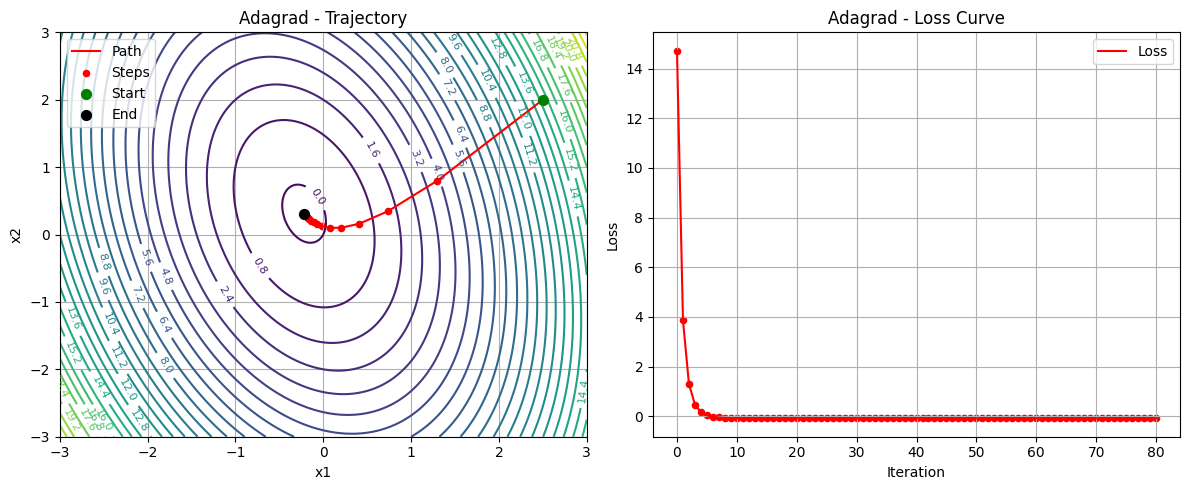

In [ ]:
# Function same as earlier quadratic

def adagrad(grad, x0, lr=0.5, steps=100, eps=1e-8):
    x = x0.copy().astype(float)
    g2 = np.zeros_like(x)
    traj=[x.copy()]; losses=[f_quad(x)]
    for i in range(steps):
        g = grad(x)
        g2 += g**2
        x = x - lr*g/(np.sqrt(g2)+eps)
        traj.append(x.copy()); losses.append(f_quad(x))
    return np.array(traj), np.array(losses)


traj_adagrad, losses_adagrad = adagrad(grad_quad, x0, lr=1.2, steps=80)
plot_contour_and_loss(Q, b, traj_adagrad, losses_adagrad, 'Adagrad', 'r')

## **5.2 ] EWMA Smoothing**

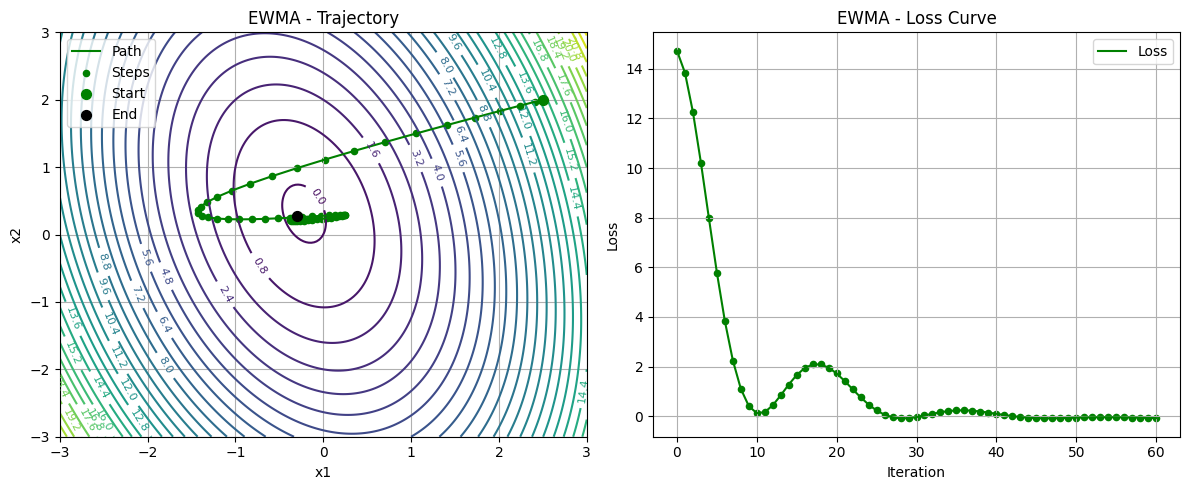

In [ ]:
# EWMA smoothing of gradients (for visualization) - exponential moving average of grads
def ewma_grads(grad, x0, lr=0.1, beta=0.9, steps=60):
    x = x0.copy().astype(float)
    s = np.zeros_like(x)
    traj=[x.copy()]; losses=[f_quad(x)]
    for i in range(steps):
        g = grad(x)
        s = beta*s + (1-beta)*g
        x = x - lr*s
        traj.append(x.copy()); losses.append(f_quad(x))
    return np.array(traj), np.array(losses)


traj_ewma, losses_ewma = ewma_grads(grad_quad, x0)
plot_contour_and_loss(Q, b, traj_ewma, losses_ewma, 'EWMA', 'g')

## **5.3 ] RMSProp**

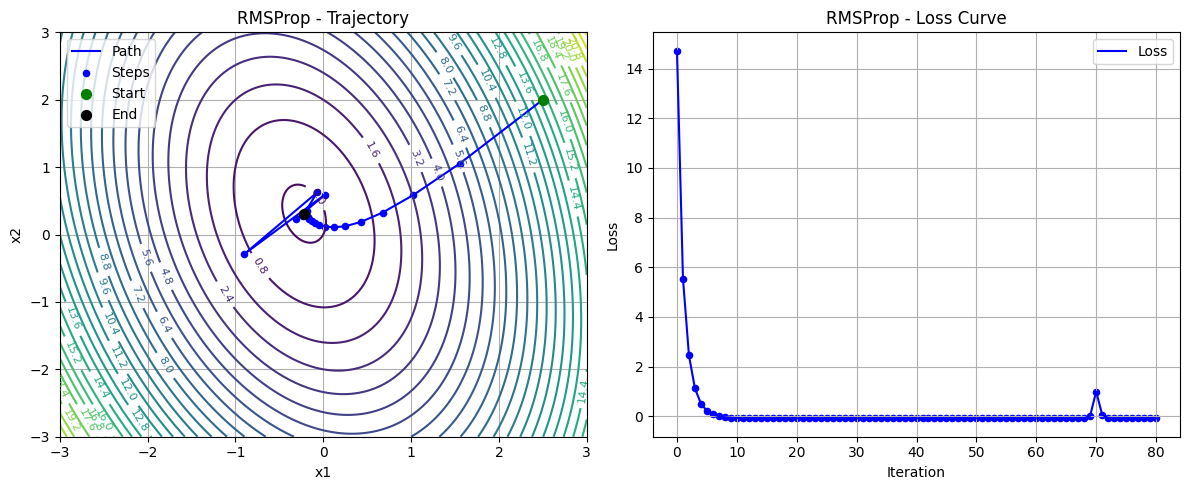

In [ ]:
# RMSProp
def rmsprop(grad, x0, lr=0.3, beta=0.9, eps=1e-8, steps=80):
    x = x0.copy().astype(float)
    E = np.zeros_like(x)
    traj=[x.copy()]; losses=[f_quad(x)]
    for i in range(steps):
        g = grad(x)
        E = beta*E + (1-beta)*(g**2)
        x = x - lr*g/(np.sqrt(E)+eps)
        traj.append(x.copy()); losses.append(f_quad(x))
    return np.array(traj), np.array(losses)


traj_rms, losses_rms = rmsprop(grad_quad, x0)
plot_contour_and_loss(Q, b, traj_rms, losses_rms, 'RMSProp', 'b')

## **5.4 ] Adam**

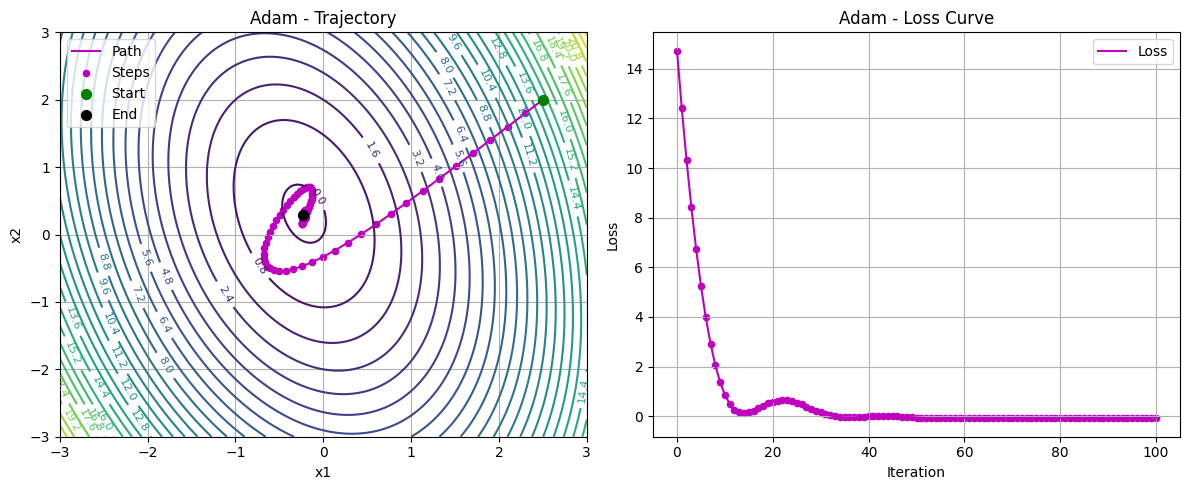

In [ ]:
# Adam
def adam(grad, x0, lr=0.2, b1=0.9, b2=0.999, eps=1e-8, steps=100):
    x = x0.copy().astype(float)
    m = np.zeros_like(x); v = np.zeros_like(x)
    traj=[x.copy()]; losses=[f_quad(x)]
    for t in range(1,steps+1):
        g = grad(x)
        m = b1*m + (1-b1)*g
        v = b2*v + (1-b2)*(g**2)
        mhat = m/(1-b1**t)
        vhat = v/(1-b2**t)
        x = x - lr*mhat/(np.sqrt(vhat)+eps)
        traj.append(x.copy()); losses.append(f_quad(x))
    return np.array(traj), np.array(losses)


traj_adam, losses_adam = adam(grad_quad, x0)
plot_contour_and_loss(Q, b, traj_adam, losses_adam, 'Adam', 'm')

## **5.5 ] Comparison**

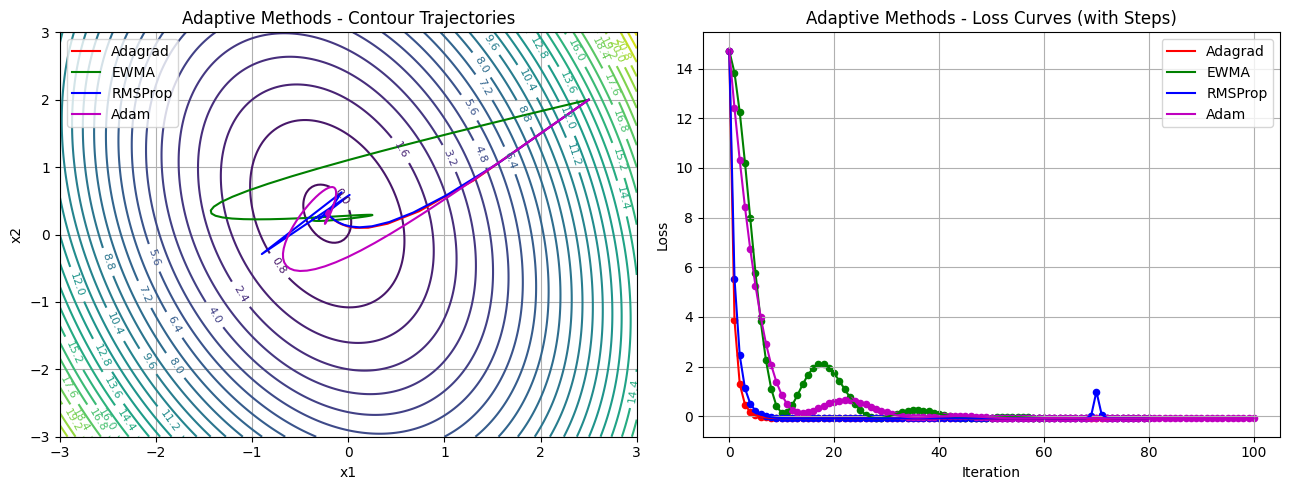

In [ ]:
# ---------- Combined comparison ----------
fig, ax = plt.subplots(1, 2, figsize=(13,5))

# Left: contour comparison
x = np.linspace(-3,3,200)
y = np.linspace(-3,3,200)
X,Y = np.meshgrid(x,y)
Z = 0.5*(Q[0,0]*X**2 + 2*Q[0,1]*X*Y + Q[1,1]*Y**2) + b[0]*X + b[1]*Y
cs = ax[0].contour(X,Y,Z,30)
ax[0].clabel(cs, inline=1, fontsize=8)
ax[0].plot(traj_adagrad[:,0], traj_adagrad[:,1], 'r', label='Adagrad')
ax[0].plot(traj_ewma[:,0], traj_ewma[:,1], 'g', label='EWMA')
ax[0].plot(traj_rms[:,0], traj_rms[:,1], 'b', label='RMSProp')
ax[0].plot(traj_adam[:,0], traj_adam[:,1], 'm', label='Adam')
ax[0].set_title('Adaptive Methods - Contour Trajectories')
ax[0].set_xlabel('x1'); ax[0].set_ylabel('x2')
ax[0].legend(); ax[0].grid(True)

# Right: combined loss curves
ax[1].plot(losses_adagrad, 'r', label='Adagrad')
ax[1].scatter(np.arange(len(losses_adagrad)), losses_adagrad, color='r', s=20)
ax[1].plot(losses_ewma, 'g', label='EWMA')
ax[1].scatter(np.arange(len(losses_ewma)), losses_ewma, color='g', s=20)
ax[1].plot(losses_rms, 'b', label='RMSProp')
ax[1].scatter(np.arange(len(losses_rms)), losses_rms, color='b', s=20)
ax[1].plot(losses_adam, 'm', label='Adam')
ax[1].scatter(np.arange(len(losses_adam)), losses_adam, color='m', s=20)
ax[1].set_title('Adaptive Methods - Loss Curves (with Steps)')
ax[1].set_xlabel('Iteration'); ax[1].set_ylabel('Loss')
ax[1].legend(); ax[1].grid(True)

plt.tight_layout()
plt.show()

# **6] Subgradient: Lasso (L1) and Ridge (L2)**

Objective:
----------
Demonstrate subgradient descent for L1 (Lasso) regularization and standard
gradient descent for L2 (Ridge) regularization on a simple one-dimensional
linear regression model (single scalar parameter w).

Notes:
------
- Lasso uses subgradients since |w| is non-differentiable at w=0.
- Ridge is differentiable (quadratic penalty) and uses standard gradient descent.
- For visualization, the loss landscape is 1D (loss vs w), so we plot the curve
  and the evolution of w over iterations.

In [ ]:
print('\nSECTION 6: Subgradient methods for Lasso and Ridge')


# We'll perform simple 1D Lasso and Ridge on synthetic y = 3*x + noise
X1 = np.linspace(-3,3,200)
y1 = 3*X1 + np.random.randn(len(X1))*1.5


SECTION 6: Subgradient methods for Lasso and Ridge


## **Subgradient for Lasso (L1)**

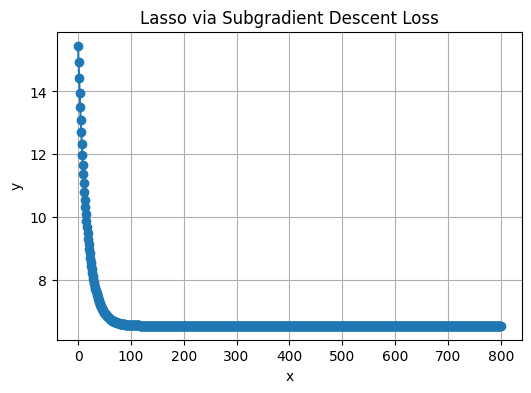

In [ ]:
# We'll fit a scalar slope 'w' with no bias, minimizing (1/2n)||Xw - y||^2 + lambda*|w| (L1)


def lasso_subgradient(X, y, lam=1.0, lr=0.01, steps=1000):
    """
    Minimize: (1/2n) ||Xw - y||^2 + lambda * |w|
    Subgradient for |w| is sign(w), and at w=0 any value in [-1,1] is valid;
    we sample randomly at w=0 for demonstration.
    """
    w = 0.0
    traj=[w]; losses=[0.5*np.mean((X*w - y)**2) + lam*abs(w)]
    for t in range(steps):
        grad = np.mean((X*w - y)*X) # derivative of MSE part
        # subgradient of |w|
        sub = np.sign(w) if w!=0 else np.random.choice([-1.0,1.0])
        w = w - lr*(grad + lam*sub)
        traj.append(w); losses.append(0.5*np.mean((X*w - y)**2) + lam*abs(w))
    return np.array(traj), np.array(losses)


traj_lasso, losses_lasso = lasso_subgradient(X1, y1, lam=2.0, lr=0.01, steps=800)
plot_trajectory(np.arange(len(losses_lasso)), losses_lasso, 'Lasso via Subgradient Descent Loss')

## **Subgradient for Ridge (L2) - (subgradient equals gradient since differentiable)**

In [ ]:
# Ridge (subgradient equals gradient since differentiable)
def ridge_gd(X,y,lam=1.0,lr=0.01,steps=200):
  """
    Minimize: (1/2n) ||Xw - y||^2 + (lambda/2) * w^2
    Standard gradient descent applies because the objective is differentiable.
    """
    w = 0.0
    traj=[w]; losses=[0.5*np.mean((X*w - y)**2) + 0.5*lam*w**2]
    for t in range(steps):
        grad = np.mean((X*w - y)*X) + lam*w
        w = w - lr*grad
        traj.append(w); losses.append(0.5*np.mean((X*w - y)**2) + 0.5*lam*w**2)
    return np.array(traj), np.array(losses)


traj_ridge, losses_ridge = ridge_gd(X1, y1, lam=2.0, lr=0.01, steps=200)
plot_trajectory(np.arange(len(losses_ridge)), losses_ridge, 'Ridge (GD) Loss')

IndentationError: unexpected indent (ipython-input-14412556.py, line 7)

# **7] Newton’s Method — Root Finding, Optimization, and Visualization**

Objective:
-----------
Demonstrate Newton’s method for:
  (a) finding roots of scalar functions,
  (b) finding minima of multivariate quadratics,
  (c) illustrating the one-step convergence property on quadratic functions.

Concept:
--------
1. Newton’s method iteratively updates:

       x_{k+1} = x_k - f(x_k)/f'(x_k)      (root finding)

2. For optimization, it uses the Hessian:

       x_{k+1} = x_k - H^{-1} ∇f(x_k)
       
   which often yields rapid (quadratic) convergence near optima.

In [ ]:
print('\nSECTION 7: Newton\'s method')


SECTION 7: Newton's method


## **7.1 ] Newton for root of scalar function**

Newton root iterates (x^2-2): [1.         1.5        1.41666667 1.41421569 1.41421356 1.41421356
 1.41421356]


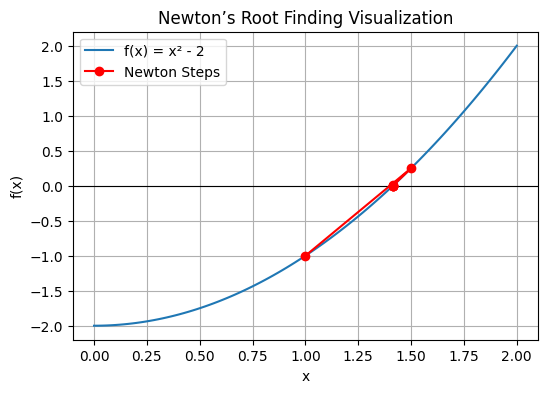

In [ ]:
# --- Newton for root of scalar function ---
def newton_root(f, df, x0, steps=10):
    x = x0
    traj = [x]
    for i in range(steps):
        x = x - f(x)/df(x)
        traj.append(x)
    return np.array(traj)

# Example: find root of g(x)=x^2 - 2
f = lambda x: x**2 - 2
df = lambda x: 2*x
root_traj = newton_root(f, df, 1.0, steps=6)
print('Newton root iterates (x^2-2):', root_traj)

# --- Visualization: Newton root finding ---
xs = np.linspace(0, 2, 100)
plt.figure(figsize=(6,4))
plt.plot(xs, f(xs), label='f(x) = x² - 2')
plt.axhline(0, color='k', linewidth=0.8)
plt.plot(root_traj, f(root_traj), 'ro-', label='Newton Steps')
plt.legend(); plt.title("Newton’s Root Finding Visualization")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.grid(True); plt.show()

## **7.2 ] Newton for optimization on quadratic**

Newton losses: [ 9.325      -0.08545455 -0.08545455 -0.08545455 -0.08545455 -0.08545455]


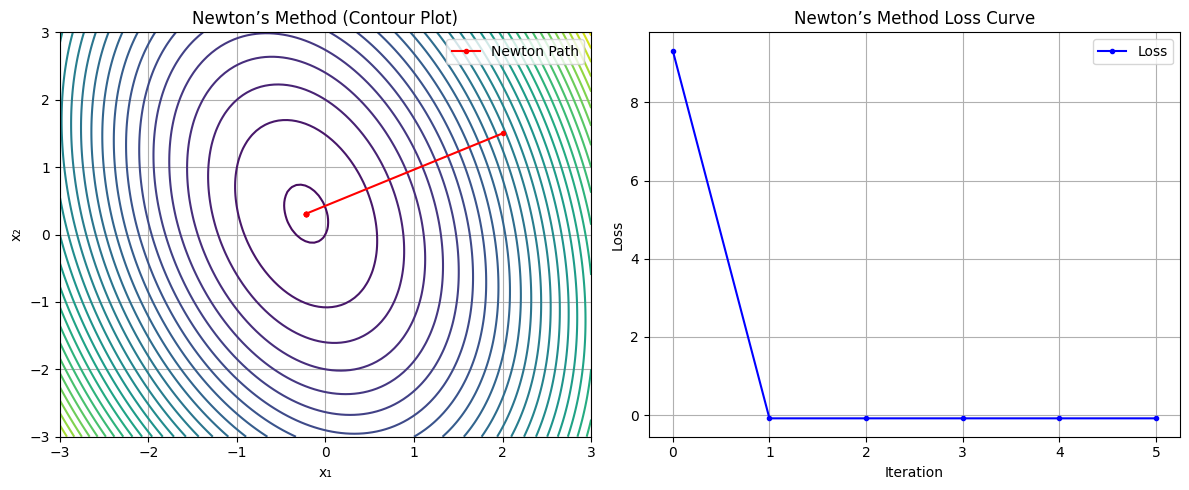

In [ ]:
# --- Newton for optimization on quadratic ---
def newton_opt(grad, hess, x0, steps=5):
    x = x0.copy().astype(float)
    traj = [x.copy()]
    losses = [f_quad(x)]
    for i in range(steps):
        H = hess(x)
        g = grad(x)
        x = x - np.linalg.solve(H, g)
        traj.append(x.copy())
        losses.append(f_quad(x))
    return np.array(traj), np.array(losses)

hess_quad = lambda x: Q
traj_newton, losses_newton = newton_opt(grad_quad, hess_quad, np.array([2.0,1.5]), steps=5)
print('Newton losses:', losses_newton)

# --- Visualization: Newton Optimization ---
# Define a meshgrid for contour visualization (added lines ↓)
x1 = np.linspace(-3, 3, 120)
x2 = np.linspace(-3, 3, 120)
X1, X2 = np.meshgrid(x1, x2)
Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x_temp = np.array([X1[i,j], X2[i,j]])
        Z[i,j] = f_quad(x_temp)   # evaluate quadratic

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].contour(X1, X2, Z, 30)
ax[0].plot(traj_newton[:,0], traj_newton[:,1], 'r.-', label='Newton Path')
ax[0].set_title("Newton’s Method (Contour Plot)")
ax[0].set_xlabel("x₁"); ax[0].set_ylabel("x₂")
ax[0].legend(); ax[0].grid(True)

ax[1].plot(losses_newton, 'b.-', label='Loss')
ax[1].set_title("Newton’s Method Loss Curve")
ax[1].set_xlabel("Iteration"); ax[1].set_ylabel("Loss")
ax[1].legend(); ax[1].grid(True)
plt.tight_layout(); plt.show()

## **7.3 ] One-step convergence on quadratic**

Analytic minimizer x* = [-0.21818182  0.30909091]
After one Newton step from [ 1.2 -0.7] -> [-0.21818182  0.30909091] (should equal x*)


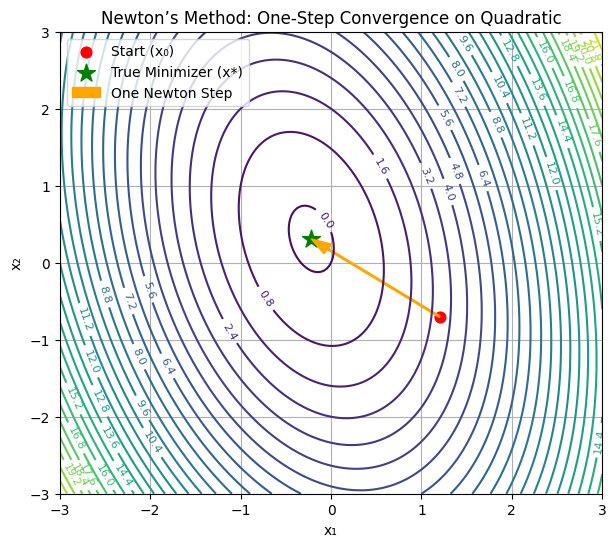

In [ ]:
# One-step convergence on quadratic: show that Newton from any x converges in one step for f(x)=0.5 x^T Q x - b^T x
# For quadratic minimizing f(x) = 0.5 x^T Q x + b^T x, Newton step equals exact minimizer using H^{-1}g.

xrand = np.array([1.2, -0.7])
x_star = -np.linalg.solve(Q, b)
print('Analytic minimizer x* =', x_star)
H = Q
g = grad_quad(xrand)
xn = xrand - np.linalg.solve(H, g)
print('After one Newton step from', xrand, '->', xn, '(should equal x*)')

# --- Visualization: One-Step Newton Convergence on Quadratic ---
x1 = np.linspace(-3, 3, 200)
x2 = np.linspace(-3, 3, 200)
X1, X2 = np.meshgrid(x1, x2)
Z = 0.5*(Q[0,0]*X1**2 + 2*Q[0,1]*X1*X2 + Q[1,1]*X2**2) + b[0]*X1 + b[1]*X2

plt.figure(figsize=(7,6))
cs = plt.contour(X1, X2, Z, 30)
plt.clabel(cs, inline=1, fontsize=8)

# Plot points
plt.scatter(xrand[0], xrand[1], color='red', s=60, label='Start (x₀)')
plt.scatter(x_star[0], x_star[1], color='green', marker='*', s=180, label='True Minimizer (x*)')

# Draw arrow showing one-step move
plt.arrow(xrand[0], xrand[1],
          x_star[0]-xrand[0], x_star[1]-xrand[1],
          color='orange', width=0.02, head_width=0.15, length_includes_head=True,
          label='One Newton Step')

plt.title("Newton’s Method: One-Step Convergence on Quadratic")
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.legend()
plt.grid(True)
plt.show()


# **8] Secant method for finding root: scalar example**

Objective:
-----------
Implement and visualize the secant method, a derivative-free variant of
Newton’s method, which approximates f′(x) using two successive points.

Update rule:

    x_{k+1} = x_k − f(x_k) * (x_k − x_{k−1}) / (f(x_k) − f(x_{k−1}))


SECTION 8: Secant method for root finding
Secant iterates: [0.5        1.5        1.375      1.41304348 1.41423002 1.41421356
 1.41421356 1.41421356]


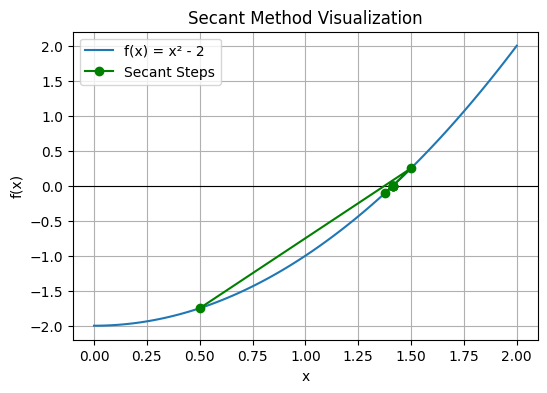

In [ ]:
print('\nSECTION 8: Secant method for root finding')


def secant(f, x0, x1, steps=10):
    xs = [x0, x1]
    for i in range(steps):
        f0 = f(xs[-2]); f1 = f(xs[-1])
        if abs(f1 - f0) < 1e-12:
            break
        x2 = xs[-1] - f1 * (xs[-1]-xs[-2]) / (f1-f0)
        xs.append(x2)
    return np.array(xs)

sec_traj = secant(lambda x: x**2 - 2, 0.5, 1.5, steps=8)
print('Secant iterates:', sec_traj)

# --- Visualization: Secant Method ---
xs = np.linspace(0, 2, 100)
plt.figure(figsize=(6,4))
plt.plot(xs, xs**2 - 2, label='f(x) = x² - 2')
plt.axhline(0, color='k', linewidth=0.8)
plt.plot(sec_traj, sec_traj**2 - 2, 'go-', label='Secant Steps')
plt.legend(); plt.title("Secant Method Visualization")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.grid(True); plt.show()

# **9] BFGS method (basic implementation) and visualisation**

Objective:
-----------
Implement the BFGS method — a quasi-Newton optimization algorithm that
approximates the inverse Hessian using gradient differences, providing
superlinear convergence without computing the true Hessian.

Concept:
--------
BFGS update:

    H_{k+1} = (I - ρ s yᵀ) H_k (I - ρ y sᵀ) + ρ s sᵀ

where  

*   s = x_{k+1} − x_k
*   y = ∇f(x_{k+1}) − ∇f(x_k),  ρ = 1/(yᵀ s)


In [ ]:
print('\nSECTION 9: BFGS')

def bfgs(grad, x0, steps=20):
    n = len(x0)
    x = x0.copy().astype(float)
    Hk = np.eye(n)
    traj = [x.copy()]
    losses = [f_quad(x)]
    for k in range(steps):
        pk = -Hk @ grad(x)
        alpha = 1.0
        c, rho = 1e-4, 0.5
        while f_quad(x + alpha*pk) > f_quad(x) + c*alpha*grad(x).dot(pk):
            alpha *= rho
        x_new = x + alpha*pk
        sk = x_new - x
        yk = grad(x_new) - grad(x)
        if sk.dot(yk) > 1e-12:
            rho_k = 1.0 / (yk.dot(sk))
            I = np.eye(n)
            Hk = (I - rho_k*np.outer(sk, yk)) @ Hk @ (I - rho_k*np.outer(yk, sk)) + rho_k*np.outer(sk, sk)
        x = x_new
        traj.append(x.copy())
        losses.append(f_quad(x))
    return np.array(traj), np.array(losses)

traj_bfgs, losses_bfgs = bfgs(grad_quad, np.array([2.5,2.0]), steps=20)
print('BFGS losses:', losses_bfgs)


SECTION 9: BFGS
BFGS losses: [14.725       4.5428125  -0.08247883 -0.0854214  -0.08545455 -0.08545455
 -0.08545455 -0.08545455 -0.08545455 -0.08545455 -0.08545455 -0.08545455
 -0.08545455 -0.08545455 -0.08545455 -0.08545455 -0.08545455 -0.08545455
 -0.08545455 -0.08545455 -0.08545455]


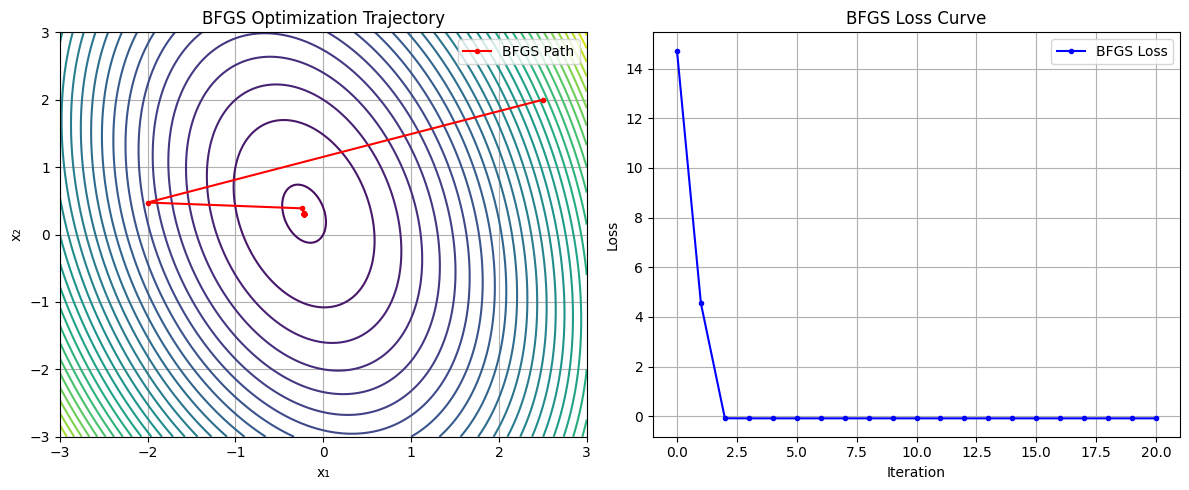

In [ ]:
# --- Visualization: BFGS ---
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].contour(X1, X2, Z, 30)
ax[0].plot(traj_bfgs[:,0], traj_bfgs[:,1], 'r.-', label='BFGS Path')
ax[0].set_title("BFGS Optimization Trajectory")
ax[0].set_xlabel("x₁"); ax[0].set_ylabel("x₂")
ax[0].legend(); ax[0].grid(True)

ax[1].plot(losses_bfgs, 'b.-', label='BFGS Loss')
ax[1].set_title("BFGS Loss Curve")
ax[1].set_xlabel("Iteration"); ax[1].set_ylabel("Loss")
ax[1].legend(); ax[1].grid(True)
plt.tight_layout(); plt.show()

# **10] Constrained optimization - Lagrange multipliers (single equality constraint)**

Objective:
-----------
Solve equality-constrained optimization problems using Lagrange multipliers.

Single constraint
-------------------------
Minimize  f(x,y) = (x−1)² + (y−2)²  subject to  g(x,y) = x + y − 1 = 0

Solution satisfies: ∇f = λ ∇g



In [ ]:
print('\nSECTION 10: Constrained optimization - single equality constraint')

# minimize f(x,y) = (x-1)^2 + (y-2)^2 subject to g(x,y) = x + y - 1 = 0
# Solve using Lagrange multiplier: grad f = lambda grad g

import sympy as sp
x, y, lam = sp.symbols('x y lam')
f_sym = (x-1)**2 + (y-2)**2
g_sym = x + y - 1
L = f_sym + lam * g_sym
sol = sp.solve([sp.diff(L, x), sp.diff(L, y), sp.diff(L, lam)], [x, y, lam])
print('Solution for constrained minimization (x,y,lambda):', sol)


SECTION 10: Constrained optimization - single equality constraint
Solution for constrained minimization (x,y,lambda): {lam: 2, x: 0, y: 1}


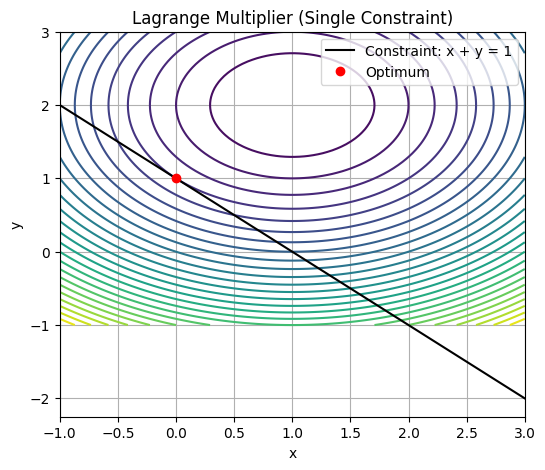

In [ ]:
# --- Visualization: Constraint + Optimum ---
sol_xy = np.array([float(sol[x]), float(sol[y])])
xx = np.linspace(-1, 3, 201)
yy = 1 - xx  # constraint line
Xg, Yg = np.meshgrid(np.linspace(-1, 3, 100), np.linspace(-1, 3, 100))
Zg = (Xg-1)**2 + (Yg-2)**2

plt.figure(figsize=(6,5))
plt.contour(Xg, Yg, Zg, 30)
plt.plot(xx, yy, 'k-', label='Constraint: x + y = 1')
plt.plot(sol_xy[0], sol_xy[1], 'ro', label='Optimum')
plt.legend(); plt.title('Lagrange Multiplier (Single Constraint)')
plt.xlabel("x"); plt.ylabel("y")
plt.grid(True); plt.show()

# **11] Two equality constraints: Solve with Lagrange multipliers (two constraints)**

Objective:
-----------
Extend the Lagrange multiplier framework to handle multiple equality constraints.

Problem:
---------
Minimize  f(x,y,z) = x² + y² + z²
Subject to:

    h₁(x,y,z): x + y + z = 1
    
    h₂(x,y,z): x − y = 0
We solve for (x, y, z, λ₁, λ₂) using symbolic differentiation.

In [ ]:
print('\nSECTION 11: Two equality constraints')

# minimize f(x,y,z) = x^2 + y^2 + z^2 subject to h1: x+y+z=1, h2: x-y=0
x,y,z,lam1,lam2 = sp.symbols('x y z lam1 lam2')
f_sym = x**2 + y**2 + z**2
h1 = x + y + z - 1
h2 = x - y
L = f_sym + lam1*h1 + lam2*h2
sol2 = sp.solve([sp.diff(L,x), sp.diff(L,y), sp.diff(L,z), sp.diff(L,lam1), sp.diff(L,lam2)], [x,y,z,lam1,lam2])
print('Solution (x,y,z,lam1,lam2):', sol2)


SECTION 11: Two equality constraints
Solution (x,y,z,lam1,lam2): {lam1: -2/3, lam2: 0, x: 1/3, y: 1/3, z: 1/3}


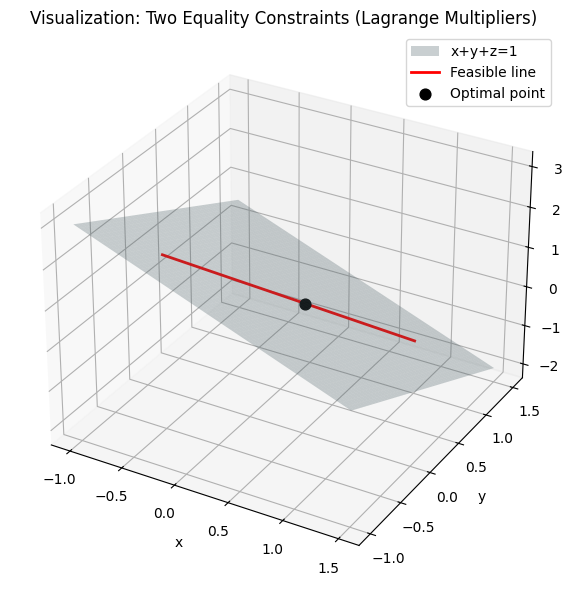

In [ ]:
# --- Visualization of constraints and optimum (new block) ---
sol_xyz = np.array([float(sol2[x]), float(sol2[y]), float(sol2[z])])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Define constraint planes
xx = np.linspace(-1, 1.5, 50)
yy = np.linspace(-1, 1.5, 50)
XX, YY = np.meshgrid(xx, yy)
Z1 = 1 - XX - YY            # Plane 1: x + y + z = 1
Z2 = YY                     # Plane 2 (x - y = 0) → y = x → z free, we’ll show its intersection line

# Plot constraint plane h1
ax.plot_surface(XX, YY, Z1, alpha=0.3, color='lightblue', label='x+y+z=1')

# Plot feasible line (intersection of both constraints)
x_line = np.linspace(-0.5, 1, 50)
y_line = x_line
z_line = 1 - 2*x_line
ax.plot(x_line, y_line, z_line, 'r-', linewidth=2, label='Feasible line')

# Mark the solution point
ax.scatter(sol_xyz[0], sol_xyz[1], sol_xyz[2], color='k', s=60, label='Optimal point')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Visualization: Two Equality Constraints (Lagrange Multipliers)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
print('\nNotebook execution complete. Each section printed and plotted its results.')


Notebook execution complete. Each section printed and plotted its results.
